# 0008_fastai_first_steps_road_to_top_part_1

In [ ]:
#| default_exp delete_road_top1

## ht: imports for vision

In [ ]:
from fastdebug.utils import *
from fastai.vision.all import *

In [ ]:
# fastlistnbs("howto")

### ht: install fastkaggle if not available else import it

In [ ]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

### ht: iterate like a grandmaster

In [Iterate Like a Grandmaster](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster) I explained that when working on a Kaggle project:

> ...the focus generally should be two things:
> 
> 1. Creating an effective validation set
> 2. Iterating rapidly to find changes which improve results on the validation set.

Here I'm going to go further, showing the process I used to tackle the [Paddy Doctor](https://www.kaggle.com/competitions/paddy-disease-classification) competition, leading to four submissions in a row which all were (at the time of submission) in 1st place, each one more accurate than the last. You might be surprised to discover that the process of doing this was nearly entirely mechanistic and didn't involve any consideration of the actual data or evaluation details at all.

This notebook is the first in a series showing every step of the process. At the end of this notebook we'll have a basic submission; by the end of the series you'll see how I got to the top of the table!:

<img src="https://user-images.githubusercontent.com/346999/174389920-60d67ead-0f36-41d0-9649-e23b08720c8a.png" width="600"/>

### what are the related walkthrus on paddy doctor competition

As a special extra, I'm also opening up early a selection of "walkthru" videos that we've been preparing for the new upcoming fast.ai course. Each day I do a walkthru with fast.ai fellows and registered students, and we record those sessions. They'll all be released at the same time as the next course (probably August 2022), but I'm releasing the ones covering this competition right now! Here they are:

- [Walkthru 8](https://www.youtube.com/watch?v=-Scs4gbwWXg)
- [Walkthru 9](https://www.youtube.com/watch?v=EK5wJRzffas)
- [Walkthru 10](https://youtu.be/zhBRynq9Yvo)
- [Walkthru 11](https://youtu.be/j-zMF2VirA8)
- [Walkthru 12](https://youtu.be/GuCkpjXHdTc)
- [Walkthru 13](https://youtu.be/INrkhUGCXHg)

## ht: download and access kaggle competition dataset

### ht: set up before downloading
go to kaggle.com, account, api, and click create a new api token

then `cp kaggle.json ~/.kaggle/`

go to the competition site and join the competition, and get the fullname of the competition for downloading the dataset

First, we'll get the data. I've just created a new library called [fastkaggle](https://fastai.github.io/fastkaggle/) which has a few handy features, including getting the data for a competition correctly regardless of whether we're running on Kaggle or elsewhere. Note you'll need to first accept the competition rules and join the competition, and you'll need your kaggle API key file `kaggle.json` downloaded if you're running this somewhere other than on Kaggle. `setup_comp` is the function we use in `fastkaggle` to grab the data, and install or upgrade our needed python modules when we're running on Kaggle:

### src: setup_comp(comp, install='fastai "timm>=0.6.2.dev0")
Get a path to data for `competition`, downloading it if needed

In [ ]:
@snoop
def setup_comp(competition, install=''):
    "Get a path to data for `competition`, downloading it if needed"
    if iskaggle:
        if install:
            os.system(f'pip install -Uqq {install}')
        return Path('../input')/competition
    else:
        path = Path(competition)
        api = import_kaggle()
        if not path.exists():
            import zipfile
            api.competition_download_cli(str(competition))
            zipfile.ZipFile(f'{competition}.zip').extractall(str(competition))
        return path
# File:      ~/mambaforge/lib/python3.9/site-packages/fastkaggle/core.py
# Type:      function

In [ ]:
"on kaggle" if iskaggle else "not on kaggle"

'not on kaggle'

In [ ]:
# whatinside(fu, dun=True)


In [ ]:
nb_path()

<IPython.core.display.Javascript object>

'/Users/Natsume/Documents/fastdebug/nbs/fastai_notebooks/'

In [ ]:
comp = '/Users/Natsume/Documents/paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

11:49:13.34 >>> Call to setup_comp in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_2242/1008324063.py", line 2
11:49:13.34 ...... competition = '/Users/Natsume/Documents/paddy-disease-classification'
11:49:13.34 ...... install = 'fastai "timm>=0.6.2.dev0"'
11:49:13.34    2 | def setup_comp(competition, install=''):
11:49:13.34    4 |     if iskaggle:
11:49:13.34    9 |         path = Path(competition)
11:49:13.35 .............. path = Path('/Users/Natsume/Documents/paddy-disease-classification')
11:49:13.35   10 |         api = import_kaggle()
11:49:13.38 .............. api = <kaggle.api.kaggle_api_extended.KaggleApi object>
11:49:13.38   11 |         if not path.exists():
11:49:13.38   15 |         return path
11:49:13.38 <<< Return value from setup_comp: Path('/Users/Natsume/Documents/paddy-disease-classification')


In [ ]:
path.ls()

(#4) [Path('/Users/Natsume/Documents/paddy-disease-classification/test_images'),Path('/Users/Natsume/Documents/paddy-disease-classification/train.csv'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images'),Path('/Users/Natsume/Documents/paddy-disease-classification/sample_submission.csv')]

In [ ]:
def setup_comp(competition, install=''):
    "Get a path to data for `competition`, downloading it if needed"
    if iskaggle:
        if install:
            os.system(f'pip install -Uqq {install}')
        return Path('../input')/competition
    else:
        path = Path(competition)
        api = import_kaggle()
        if not path.exists():
            import zipfile
            api.competition_download_cli(str(competition))
            zipfile.ZipFile(f'{competition}.zip').extractall(str(competition))
        return path
# File:      ~/mambaforge/lib/python3.9/site-packages/fastkaggle/core.py
# Type:      function

### ht: reproducibility in training

Now we can import the stuff we'll need from fastai, set a seed (for reproducibility -- just for the purposes of making this notebook easier to write; I don't recommend doing that in your own analysis however) and check what's in the data:

In [ ]:
set_seed(42)

## ht: data - access dataset

### ht: data - map subfolders content
use `path.ls()` and `check_subfolders_img(path)` to see what inside each subfolders

In [ ]:
path.ls()

(#4) [Path('/Users/Natsume/Documents/paddy-disease-classification/test_images'),Path('/Users/Natsume/Documents/paddy-disease-classification/train.csv'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images'),Path('/Users/Natsume/Documents/paddy-disease-classification/sample_submission.csv')]

### src: check_subfolders_img(path, db=False)

In [ ]:
#| export utils 
from fastai.vision.all import *

In [ ]:
#| export utils
# @snoop
def check_subfolders_img(path, db=False):
    from pathlib import Path
    for entry in path.iterdir():
        if entry.is_file():
            print(f'{str(entry.absolute())}')
    addup = 0
    for entry in path.iterdir():
        if entry.is_dir() and not entry.name.startswith(".") and len(entry.ls(file_exts=image_extensions)) > 5:
            addup += len(entry.ls(file_exts=image_extensions))
            print(f'{str(entry.parent.absolute())}: {len(entry.ls(file_exts=image_extensions))}  {entry.name}')
#             print(entry.name, f': {len(entry.ls(file_exts=[".jpg", ".png", ".jpeg", ".JPG", ".jpg!d"]))}') # how to include both png and jpg
            if db:
                for e in entry.ls(): # check any image file which has a different suffix from those above
                    if e.is_file() and not e.name.startswith(".") and e.suffix not in image_extensions and e.suffix not in [".ipynb", ".py"]:
    #                 if e.suffix not in [".jpg", ".png", ".jpeg", ".JPG", ".jpg!d"]:
                        pp(e.suffix, e)
                        try:
                            pp(Image.open(e).width)
                        except:
                            print(f"{e} can't be opened")
    #                     pp(Image.open(e).width if e.suffix in image_extensions)
        elif entry.is_dir() and not entry.name.startswith("."): 
#             with snoop:
            check_subfolders_img(entry)
    print(f"addup num: {addup}")

In [ ]:
check_subfolders_img(path)

/Users/Natsume/Documents/paddy-disease-classification/train.csv
/Users/Natsume/Documents/paddy-disease-classification/sample_submission.csv
/Users/Natsume/Documents/paddy-disease-classification: 3469  test_images
/Users/Natsume/Documents/paddy-disease-classification/train_images: 1442  dead_heart
/Users/Natsume/Documents/paddy-disease-classification/train_images: 337  bacterial_panicle_blight
/Users/Natsume/Documents/paddy-disease-classification/train_images: 479  bacterial_leaf_blight
/Users/Natsume/Documents/paddy-disease-classification/train_images: 965  brown_spot
/Users/Natsume/Documents/paddy-disease-classification/train_images: 1594  hispa
/Users/Natsume/Documents/paddy-disease-classification/train_images: 620  downy_mildew
/Users/Natsume/Documents/paddy-disease-classification/train_images: 1738  blast
/Users/Natsume/Documents/paddy-disease-classification/train_images: 1764  normal
/Users/Natsume/Documents/paddy-disease-classification/train_images: 380  bacterial_leaf_streak
/Us

### ht: data - extract all images for test and train with `get_image_files`

In [ ]:
test_files = get_image_files(path/"test_images")
train_files = get_image_files(path/"train_images")

In [ ]:
test_files
train_files

(#3469) [Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/202919.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/200868.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/200698.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/200840.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/201586.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/203391.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/202931.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/202925.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/203385.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/200854.jpg')...]

(#10407) [Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/110369.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/105002.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/106279.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/108254.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/104308.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/107629.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/110355.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/100146.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/103329.jpg'),Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/105980.jpg')...]

In [ ]:
# fastnbs("src: get_image_files")

...and take a look at one:

### ht: data - display an image from test_files or train_files
use `randomdisplay(path, size, db=False)` to display images from a folder or a L list of images such as `test_files` or `train_files`

### src: randomdisplay(path, size, db=False)
display a random images from a L list (eg., test_files, train_files) of image files or from a path/folder of images.\
    the image filename is printed as well

In [ ]:
import pathlib
type(path) == pathlib.PosixPath
type(train_files) == L

True

True

In [ ]:
#| export utils
# @snoop
def randomdisplay(path, size=128, db=False):
    "display a random images from a L list (eg., test_files, train_files) of image files or from a path/folder of images.\
    the image filename is printed as well"
# https://www.geeksforgeeks.org/python-random-module/
    import random
    import pathlib
    from fastai.vision.all import PILImage
    if type(path) == pathlib.PosixPath:
        rand = random.randint(0,len(path.ls())-1) 
        file = path.ls()[rand]
    elif type(path) == L:
        rand = random.randint(0,len(path)-1) 
        file = path[rand]
    im = PILImage.create(file)
    if db: pp(im.width, im.height, file)
    pp(file)
    return im.to_thumb(size)

11:49:13.83 LOG:
11:49:13.97 .... file = Path('/Users/Natsume/Documents/paddy-disease-classification/test_images/201216.jpg')


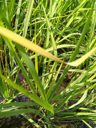

11:49:13.98 LOG:
11:49:13.98 .... file = Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/bacterial_leaf_blight/104518.jpg')


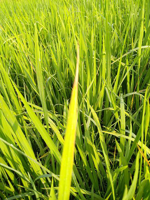

11:49:13.99 LOG:
11:49:13.99 .... file = Path('/Users/Natsume/Documents/paddy-disease-classification/train_images/dead_heart/100966.jpg')


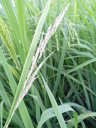

In [ ]:
randomdisplay(test_files, 128)
randomdisplay(train_files, 200)
randomdisplay(path/"train_images/dead_heart", 128)

### ht: data - clean - remove images that fail to open with `remove_failed(path)`

In [ ]:
remove_failed(path)

before running remove_failed:
/Users/Natsume/Documents/paddy-disease-classification/train.csv
/Users/Natsume/Documents/paddy-disease-classification/sample_submission.csv
/Users/Natsume/Documents/paddy-disease-classification: 3469  test_images
/Users/Natsume/Documents/paddy-disease-classification/train_images: 1442  dead_heart
/Users/Natsume/Documents/paddy-disease-classification/train_images: 337  bacterial_panicle_blight
/Users/Natsume/Documents/paddy-disease-classification/train_images: 479  bacterial_leaf_blight
/Users/Natsume/Documents/paddy-disease-classification/train_images: 965  brown_spot
/Users/Natsume/Documents/paddy-disease-classification/train_images: 1594  hispa
/Users/Natsume/Documents/paddy-disease-classification/train_images: 620  downy_mildew
/Users/Natsume/Documents/paddy-disease-classification/train_images: 1738  blast
/Users/Natsume/Documents/paddy-disease-classification/train_images: 1764  normal
/Users/Natsume/Documents/paddy-disease-classification/train_images: 

### ht: data - describe sizes of all images with `check_sizes_img`

Looks like the images might be 480x640 -- let's check all their sizes. This is faster if we do it in parallel, so we'll use fastcore's `parallel` for this:

In [ ]:
PILImage

fastai.vision.core.PILImage

### src: check_sizes_img(files)


In [ ]:
#| export utils
def f(o, sz=None): 
    im = None
    if sz and PILImage.create(o).size == sz:
        im = PILImage.create(o).to_thumb(500)
    return PILImage.create(o).size, im

In [ ]:
# from fastcore.parallel import parallel
# doc(parallel)

In [ ]:
#| export utils
# @snoop
@delegates(f)
def check_sizes_img(files, **kwargs):
    "use fastcore.parallel to quickly find out the different sizes of all images and their occurences. \
    output images with specific sizes if specified in `sz`"
    from fastcore.parallel import parallel
    res = parallel(f, files, n_workers=8, **kwargs) # add sz as a keyword to parallel
    sizes = [size for size, im in res]
    imgs = [im for size, im in res if im != None]
    pp(pd.Series(sizes).value_counts())  
    pp(imgs)
    if len(imgs):
        for im in imgs:
            im.to_thumb(125).show()
    return imgs

In [ ]:
check_sizes_img(train_files)

/Users/Natsume/mambaforge/lib/python3.9/site-packages/cheap_repr/__init__.py:156: ReprSuppressedWarning: L.__repr__ is too long and has been suppressed. Register a repr for the class to avoid this warning and see an informative repr again, or increase cheap_repr.suppression_threshold
  warnings.warn(ReprSuppressedWarning(
11:49:23.66 >>> Call to check_sizes_img in File "/var/folders/gz/ch3n2mp51m9386sytqf97s6w0000gn/T/ipykernel_2242/4105120190.py", line 4
11:49:23.66 ...... files = [Path('/Users/Natsume/Documents/paddy-disease-cl...-classification/train_images/tungro/100163.jpg')]
11:49:23.66 ...... kwargs = {}
11:49:23.66    4 | def check_sizes_img(files, **kwargs):
11:49:23.66 ...... files = <L instance at 0x11f2affa0 (repr suppressed)>
11:49:23.66    7 |     from fastcore.parallel import parallel
11:49:23.66 .......... parallel = <function parallel>
11:49:23.66    8 |     res = parallel(f, files, n_workers=8, **kwargs) # add sz as a keyword to parallel
11:49:32.72 .......... res = <

[]

In [ ]:
imgs = check_sizes_img(test_files, sz = (640, 480))

11:49:54.63 LOG:
11:49:54.64 .... pd.Series(sizes).value_counts() = (480, 640)    3467
11:49:54.64                                        (640, 480)       2
11:49:54.64                                        dtype: int64
11:49:54.64 LOG:
11:49:54.64 .... imgs = [<PIL.Image.Image image mode=RGB size=500x375>,
11:49:54.64              <PIL.Image.Image image mode=RGB size=500x375>]


### qt: how to display a list of images?

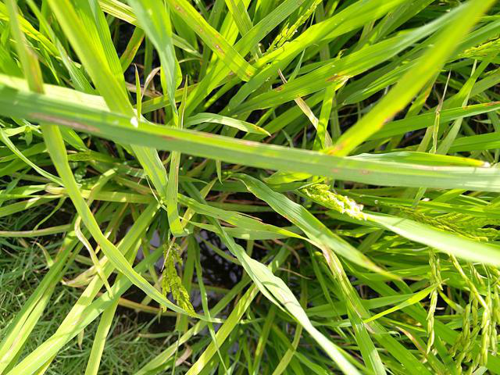

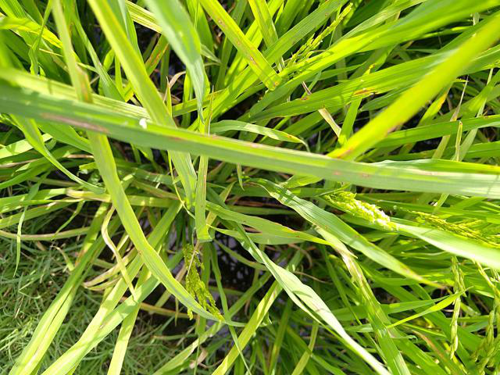

In [ ]:
imgs[0] 
imgs[1]


### how to create an image dataloaders; how to setup `item_tfms` and `batch_tfms` on image sizes; why to start with the smallest sizes first; how to display images in batch

They're nearly all the same size, except for a few. Because of those few, however, we'll need to make sure we always resize each image to common dimensions first, otherwise fastai won't be able to create batches. For now, we'll just squish them to 480x480 images, and then once they're in batches we do a random resized crop down to a smaller size, along with the other default fastai augmentations provided by `aug_transforms`. We'll start out with small resized images, since we want to be able to iterate quickly:

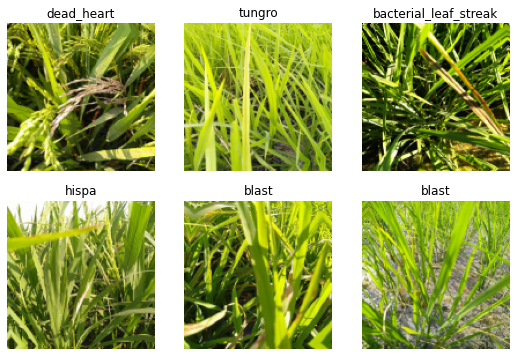

In [ ]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

## Our first model

### how to pick the first pretrained model for our model; how to build our model based on the selected pretrained model

Let's create a model. To pick an architecture, we should look at the options in [The best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning). I like the looks of `resnet26d`, which is the fastest resolution-independent model which gets into the top-15 lists there.

In [ ]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

### how to find the learning rate for our model

Let's see what the learning rate finder shows:

SuggestedLRs(valley=0.0008317637839354575, slide=0.0030199517495930195)

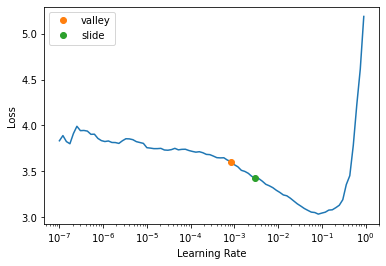

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

`lr_find` generally recommends rather conservative learning rates, to ensure that your model will train successfully. I generally like to push it a bit higher if I can. Let's train a few epochs and see how it looks:

In [ ]:
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.805964,1.233453,0.403652,00:14


epoch,train_loss,valid_loss,error_rate,time
0,1.129876,0.785891,0.266218,00:15
1,0.777808,0.456637,0.143681,00:15
2,0.557498,0.407197,0.136473,00:15


We're now ready to build our first submission. Let's take a look at the sample Kaggle provided to see what it needs to look like:

## Submitting to Kaggle

### how to check the kaggle submission sample csv file

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


### how to sort the files in the test set in the alphabetical order; how to create dataloaders for the test set based on the dataloaders of the training set

OK so we need a CSV containing all the test images, in alphabetical order, and the predicted label for each one. We can create the needed test set using fastai like so:

In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

### how to make predictions for all test set; and what does `learn.get_preds` return

We can now get the probabilities of each class, and the index of the most likely class, from this test set (the 2nd thing returned by `get_preds` are the targets, which are blank for a test set, so we discard them):

In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([7, 8, 7,  ..., 8, 7, 5])

### how to access all the classes of labels with dataloaders

These need to be mapped to the names of each of these diseases, these names are stored by fastai automatically in the `vocab`:

In [ ]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

### how to map classes to each idx from the predictions

We can create an apply this mapping using pandas:

In [ ]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0            hispa
1           normal
2            hispa
3            blast
4            blast
           ...    
3464    dead_heart
3465         hispa
3466        normal
3467         hispa
3468    dead_heart
Name: idxs, Length: 3469, dtype: object

### how to save result into csv file

Kaggle expects the submission as a CSV file, so let's save it, and check the first few lines:

In [ ]:
ss['label'] = results
ss.to_csv('subm.csv', index=False)
!head subm.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,hispa
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


### how to submit to kaggle with fastkaggle api

Let's submit this to kaggle. We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [ ]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████████████████████████████████████| 70.0k/70.0k [00:05<00:00, 13.8kB/s]


Successfully submitted to Paddy Doctor: Paddy Disease Classification

Success! We successfully created a submission.

## Conclusion

### what is the most important thing for your first model

Our initial submission is not very good (top 80% of teams) but it only took a minute to train. The important thing is that we have a good starting point to iterate from, and we can do rapid iterations. Every step from loading the data to creating the model to submitting to Kaggle is all automated and runs quickly.

Therefore, we can now try lots of things quickly and easily and use those experiments to improve our results. In the next notebook, we'll do exactly that!

If you found this notebook useful, please remember to click the little up-arrow at the top to upvote it, since I like to know when people have found my work useful, and it helps others find it too. And if you have any questions or comments, please pop them below -- I read every comment I receive!

## Addendum

### how to quickly push your local notebook to become kaggle notebook online

`fastkaggle` also provides a function that pushes a notebook to Kaggle Notebooks. I wrote this notebook on my own machine, and pushed it to Kaggle from there -- here's the command I used:

In [ ]:
if not iskaggle:
    push_notebook('jhoward', 'first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)

Kernel version 10 successfully pushed.  Please check progress at https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1


In [ ]:
from fastdebug.utils import *

In [ ]:
nb_name()

'0008_fastai_first_steps_road_to_top_part_1.ipynb'

In [ ]:
ipy2md()

[jupytext] Reading /Users/Natsume/Documents/fastdebug/nbs/2022part1/0008_fastai_first_steps_road_to_top_part_1.ipynb in format ipynb
[jupytext] Writing /Users/Natsume/Documents/fastdebug/nbs/2022part1/0008_fastai_first_steps_road_to_top_part_1.md
cp to : /Users/Natsume/Documents/divefastai/Debuggable/jupytext
move to : /Users/Natsume/Documents/fastdebug/mds/2022part1/


[NbConvertApp] Converting notebook /Users/Natsume/Documents/fastdebug/nbs/2022part1/0008_fastai_first_steps_road_to_top_part_1.ipynb to markdown


copy to : /Users/Natsume/Documents/fastdebug/mds_output
move to : /Users/Natsume/Documents/divefastai/Debuggable/nbconvert


[NbConvertApp] Support files will be in 0008_fastai_first_steps_road_to_top_part_1_files/
[NbConvertApp] Making directory /Users/Natsume/Documents/fastdebug/nbs/2022part1/0008_fastai_first_steps_road_to_top_part_1_files
[NbConvertApp] Making directory /Users/Natsume/Documents/fastdebug/nbs/2022part1/0008_fastai_first_steps_road_to_top_part_1_files
[NbConvertApp] Making directory /Users/Natsume/Documents/fastdebug/nbs/2022part1/0008_fastai_first_steps_road_to_top_part_1_files
[NbConvertApp] Writing 20191 bytes to /Users/Natsume/Documents/fastdebug/nbs/2022part1/0008_fastai_first_steps_road_to_top_part_1.md


In [ ]:
fastnbs("push kaggle")

### how to quickly <mark style="background-color: #ffff00">push</mark>  your local notebook to become <mark style="background-color: #FFFF00">kaggle</mark>  notebook online




`fastkaggle` also provides a function that pushes a notebook to Kaggle Notebooks. I wrote this notebook on my own machine, and pushed it to Kaggle from there -- here's the command I used:

```python
if not iskaggle:
    push_notebook('jhoward', 'first-steps-road-to-the-top-part-1',
                  title='First Steps: Road to the Top, Part 1',
                  file='first-steps-road-to-the-top-part-1.ipynb',
                  competition=comp, private=False, gpu=True)
```

```python

```

```python
from fastdebug.utils import *
```

```python
nb_name()
```

```python
ipy2md()
```

```python
fastnbs("push kaggle")
```

```python

```


[Open `0008_fastai_first_steps_road_to_top_part_1` in Jupyter Notebook locally](http://localhost:8888/tree/nbs/2022part1/0008_fastai_first_steps_road_to_top_part_1.ipynb)

[Open `0008_fastai_first_steps_road_to_top_part_1` in Jupyter Notebook on Kaggle](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1)